In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt*
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
import tensorflow as tf
import scipy.io as sio
from scipy.io import loadmat, savemat
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler

2022-03-01 15:57:06.938525: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-03-01 15:57:06.938544: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [39]:
fileName = '8_antenna_500_samples_100_snapshots'

dataPath = '/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[1]MATLAB/DOA_DATA'


readPath = dataPath +'/' + fileName
print(readPath)

rootPath = '/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[3]Pytorch/[1]DOA_implementation'
savePath = rootPath + '/result' + '/' + fileName
if not os.path.isdir(savePath):
    os.makedirs(savePath)
print(savePath)

/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[1]MATLAB/DOA_DATA/8_antenna_500_samples_100_snapshots
/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[3]Pytorch/[1]DOA_implementation/result/8_antenna_500_samples_100_snapshots


In [3]:
from sklearn.datasets import make_classification
import torch
data, target = make_classification(n_samples=1000)

In [4]:
class CustomDataset(torch.utils.data.Dataset): 
    def __init__(self,data,target):
        self.data = data
        self.target = target
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        current_sample = self.data[idx,:]
        current_target = self.target[idx]
        return {
            'sample': torch.tensor(current_sample, dtype=torch.float),
            'target': torch.tensor(current_target,dtype=torch.long)
        }

In [5]:
custom_dataset = CustomDataset(data=data, target = target)

In [6]:
len(custom_dataset)

1000

In [7]:
custom_dataset[0]['sample']

tensor([ 1.5089,  1.2295,  0.8938, -1.7735,  0.4042, -0.8870,  0.3304,  2.8960,
        -0.4011,  0.0598, -1.3440, -0.1048, -1.3017, -1.8702,  1.5285,  3.4140,
         0.6177,  0.6557, -1.1345,  0.2220])

In [40]:
# Input train noisy dataset for all snr and stack them together
dataset = tf.data.Dataset.list_files(fileName+'/*/train/train_data.*', shuffle=False)
# for i in dataset.as_numpy_iterator():
#     print(i)
data_set = []
for i in dataset.as_numpy_iterator():
    x_train = sio.loadmat(i)
    x_train = x_train['train_data']  # noisy sample covariance matrix
    data_set.append(x_train) #NOTE: put all the train_data of different SNR into one list
len(data_set) 

data_train = data_set[0]
for i in data_set:
    data_train = np.vstack((data_train,i)) # stack all the datasets vertically
    
data_train = data_train[x_train.shape[0]:] # the first dataset is included in twice
data_train.shape

(102500, 64)

In [41]:
# Input train noiseless dataset for all snr and stack them together
dataset = tf.data.Dataset.list_files(fileName + '/*/train/train_origin_data.*', shuffle=False)
# for i in dataset.as_numpy_iterator():
#     print(i)
data_set = []
for i in dataset.as_numpy_iterator():
    x_train = sio.loadmat(i)
    x_train = x_train['train_origin_data']  # noisy sample covariance matrix
    data_set.append(x_train[:x_train.shape[0],:]) #NOTE: put all the train_data of different SNR into one list
len(data_set) 

data_origin = data_set[0]
for i in data_set:
    data_origin = np.vstack((data_origin,i)) # stack all the datasets vertically
    
data_origin = data_origin[x_train.shape[0]:] # the first dataset is included in twice
data_origin.shape

(102500, 64)

In [42]:
# train data shuffle
np.random.seed(2020)
index = np.arange(data_train.shape[0])
print(index)
np.random.shuffle(index)
data_train = data_train[index]
data_origin = data_origin[index]

[     0      1      2 ... 102497 102498 102499]


In [43]:
## scaling
scaler = StandardScaler()
data_train_scale = scaler.fit_transform(np.transpose(data_train))
data_origin_scale = scaler.fit_transform(np.transpose(data_origin))
print(data_train_scale.shape)
print(data_origin_scale.shape)
data_train = np.transpose(data_train_scale)
data_origin = np.transpose(data_origin_scale)


(64, 102500)
(64, 102500)


#### Step 2: Loading the Dataset

In [13]:
# # Transforms images to a PyTorch Tensor
# # transform = transforms.Compose(
# #     [transforms.ToTensor(),
# #     transforms.Normalize((0.5,),(0.5,))]) #NOTE: change the range of the data from 0 to 1 TO -1 to 1.

In [68]:
dataset = []
for i in range(len(data_train)):
    dataset.append((data_train[i],data_origin[i]))

batch_size = 128

# # Create data loaders.
train_dataloader = DataLoader(dataset = dataset, 
                              batch_size = batch_size,
                              shuffle = True)
# test_dataloader = DataLoader(dataset = data_origin, 
#                              batch_size=batch_size,
#                              shuffle = True)

In [45]:
# for X in test_dataloader:
#     print(f"Shape of X [Batch size, Channel, Height, Width]: {X.shape}")
#     # print(f"Shape of y: {y.shape} {y.dtype}")
#     print(f'The maximum value is {torch.max(X)} and minimum value is {torch.min(X)}')
#     break
for X,Y in train_dataloader:
    print(f"Shape of X [Batch size, Channel, Height, Width]: {X.shape}")
    print(f"Shape of Y: {Y.shape} {Y.dtype}")
    print(f'The maximum value is {torch.max(X)} and minimum value is {torch.min(X)}')
    break

Shape of X [Batch size, Channel, Height, Width]: torch.Size([64, 64])
Shape of Y: torch.Size([64, 64]) torch.float64
The maximum value is 3.278346244787716 and minimum value is -1.6546467371601095


### Create Autoencoder Class

In [46]:
# Creating a PyTorch class
class AE_dense(torch.nn.Module):
    def __init__(self):
        super(AE_dense,self).__init__()
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 400 ==> 100
        self.encoder = torch.nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8), # 400, 300, 200, 100
            nn.ReLU(),
            # nn.Linear(100, 50),
            # nn.ReLU()
        )
          
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 100 ==> 400
        self.decoder = torch.nn.Sequential(
            # nn.Linear(50, 100), 
            # nn.ReLU(),
            nn.Linear(8, 16),  # 100, 200, 300, 400
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded,  
    #! NOTE! when calling model(data), it returns a tuple (decoded, encoded). 
    #! Or you can just choose the first value for training.

In [17]:
class Reshape(nn.Module):
    def __init__(self,shape):
        super(Reshape,self).__init__()
        self.shape = shape
    
    def forward(self, x):
        return x.view(*self.shape) #NOTE: '*' passes multiple parameters(but here with or without * returns the same value)
        

# Creating a PyTorch class
class AE_conv(torch.nn.Module):
    def __init__(self, latent_dim):
        super(AE_conv,self).__init__()
        # Building a convolution encoder with convolutional
        # layer followed by Relu activation function
        # 400 ==> 100
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride = 2, padding=1), # 28 * 28 -> 14 * 14
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride = 2, padding=1), # 14 * 14 -> 7 * 7
            nn.LeakyReLU(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(7*7*64, latent_dim), # second argument: latent_dim
            nn.LeakyReLU()
        )
          
        # Building an convolution decoder with convolutional
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,7*7*64),
            nn.LeakyReLU(),
            Reshape((-1,64,7,7)),
            nn.ConvTranspose2d(64,32,2, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32,1,2, stride=2),
            nn.Tanh())
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded,  
    #! NOTE! when calling model(data), it returns a tuple (decoded, encoded). 
    #! Or you can just choose the first value for training.

### Initializing models

In [79]:
from torchsummary import summary
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

writer = SummaryWriter()

latent_dim = 10

# Model Initialization
model = AE_dense().to(device)
# model = AE_conv(latent_dim).to(device)
  
# Validation using MSE Loss function
loss_fn = torch.nn.MSELoss().to(device)
  
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-2,
                             weight_decay = 1e-8)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,threshold = 0.1,patience=10,mode='min',verbose=True)
# summary(model, (1, 28*28))


Using cuda device


### Define training function 

In [19]:
def show(dataloader, model, epoch):
    '''Plot the original and reconstructed images together

    Args:
        dataloader (data_loader): an object that wraps the dataset
        model (model): autoencoder
    '''
    model.eval() #Tell the model you are going to test so the weights will not be updated
    with torch.no_grad():
        for i, X in enumerate(dataloader):
            # X = X.view(X.size(0), -1)
            X = X.type(torch.FloatTensor).to(device) # to is one of the operations(methods) in tensor object

            pred = model(X)
            reconstructed = pred[0]
            
            # plot part
            fig, axs = plt.subplots(2,1, figsize=(20,5)) # 2 means two rows
            # display the original image
            axs[0].plot(X.cpu()) ##Note axs is a matrix, you can't just write axs[], it should be axs[][]
            # display the reconstructed image
            axs[1].plot(reconstructed.cpu())

            plt.savefig(savePath+ f'/epoch-{epoch}.png')
            break
    return fig
            

/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[3]Pytorch/[1]DOA_implementation/result/with_normalization


In [80]:
def train(epochs, dataset,model, loss_fn, optimizer, scheduler):
    size = len(dataset.dataset) # return the number of training samples
    model.train() #Tell the model you are going to train so the weights will be updated
    for t in range(epochs):
        running_loss = 0.0
        # print(f"Epoch {t+1}\n-------------------------------")
        for batch, (X,Y) in enumerate(dataset): # iterates the dataloader 
            # X = X.view(X.size(0),-1)
            X = X.type(torch.FloatTensor).to(device)
            Y = Y.type(torch.FloatTensor).to(device)

            # Compute prediction error
            pred = model(X) #! NOTE: Here the returned value is a tuple (decoded, encoded) as defined in forward()
           
            loss = loss_fn(pred[0], Y) # Choose the first value pred[0] as decoded value for the purpose of training
                                        #! NOTE: the second argument should be the original value
            # Backpropagation
            optimizer.zero_grad() # to reset the gradients of model parameters.
            loss.backward() # PyTorch deposits the gradients of the loss w.r.t. each parameter.
            optimizer.step() # to adjust the parameters by the gradients collected in the backward pass.

            running_loss += loss.item()
            # if batch % 100 == 0:
            #     loss, current = loss.item(), batch * len(X)
            #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        # .. log the running loss
        writer.add_scalar('training_loss',
                            running_loss/size,
                            t)
        # writer.add_figure('predictions vs. actuals',
        #                 show(testdata, model, t, 10),
        #                 global_step=t)
        # for name, param in model.named_parameters():
        #     layer, attr = os.path.splitext(name)
        #     attr = attr[1:]
        #     writer.add_histogram(f'{layer, attr}', param.clone().cpu().data.numpy(),t)
        scheduler.step(loss)
        # show(testdata, model, t,10)
        print('Epoch: {}, Loss: {}, LR: {}'.format(t, running_loss/size, scheduler.optimizer.state_dict()['param_groups'][0]['lr']))

###  Start training and validating

In [81]:
epochs = 200
train(epochs, train_dataloader, model, loss_fn, optimizer,scheduler)
writer.flush()
print("Done!")

Epoch: 0, Loss: 0.0023592733120046012, LR: 0.01
Epoch: 1, Loss: 0.001618131673190652, LR: 0.01
Epoch: 2, Loss: 0.001556221686994157, LR: 0.01
Epoch: 3, Loss: 0.0015299019357053246, LR: 0.01
Epoch: 4, Loss: 0.0015007883757352828, LR: 0.01
Epoch: 5, Loss: 0.0014869157056982924, LR: 0.01
Epoch: 6, Loss: 0.00147144741234256, LR: 0.01
Epoch: 7, Loss: 0.0014599820946047946, LR: 0.01
Epoch: 8, Loss: 0.0014503075798110263, LR: 0.01
Epoch: 9, Loss: 0.0014506302153918802, LR: 0.01
Epoch: 10, Loss: 0.0014360243595227962, LR: 0.01
Epoch: 11, Loss: 0.0014345138146383007, LR: 0.01
Epoch: 12, Loss: 0.0014307263598209473, LR: 0.01
Epoch: 13, Loss: 0.0014249568925398153, LR: 0.01
Epoch: 14, Loss: 0.001417346787961518, LR: 0.01
Epoch    16: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 15, Loss: 0.001417860414923691, LR: 0.001
Epoch: 16, Loss: 0.0013316161151339368, LR: 0.001
Epoch: 17, Loss: 0.0013265526011949633, LR: 0.001
Epoch: 18, Loss: 0.0013242621426175281, LR: 0.001
Epoch: 19, Loss: 0.

KeyboardInterrupt: 

In [63]:
# save model
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

# load model
# model = NeuralNetwork()
# model.load_state_dict(torch.load("model.pth"))

Saved PyTorch Model State to model.pth


###  Input/Reconstructed Input to/from Autoencoder

In [58]:
# Input test noisy dataset for all snr and stack them together
dataset = tf.data.Dataset.list_files(fileName + '/-10dB/test/test_data.*', shuffle=False)
# for i in dataset.as_numpy_iterator():
#     print(i)
data_set = []
for i in dataset.as_numpy_iterator():
    x_train = sio.loadmat(i)
    x_train = x_train['test_data']  # noisy sample covariance matrix
    data_set.append(x_train) #NOTE: put all the train_data of different SNR into one list

data_test = data_set[0]
for i in data_set:
    data_test = np.vstack((data_test,i)) # stack all the datasets vertically
data_test = data_test[x_train.shape[0]:] # the first dataset is included in twice
print(data_test.shape)

# scaling
# data_test = scaler.fit_transform(data_test)
data_test_scale = scaler.fit_transform(np.transpose(data_test))
# print(data_test_scale.shape)
data_test = np.transpose(data_test_scale)
# print(data_test.shape)

# export data for MATLAB processing
print(savePath)
savePath_ = savePath + '/test_data.mat'
print(savePath_)
savemat(savePath_, {'test_data':data_test})

(500, 64)
/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[3]Pytorch/[1]DOA_implementation/result/8_antenna_500_samples_100_snapshots
/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[3]Pytorch/[1]DOA_implementation/result/8_antenna_500_samples_100_snapshots/test_data.mat


In [59]:
# Input test label dataset for all snr and stack them together
dataset = tf.data.Dataset.list_files(fileName + '/-10dB/test/test_label.*', shuffle=False)
# for i in dataset.as_numpy_iterator():
#     print(i)
data_set = []
for i in dataset.as_numpy_iterator():
    x_train = sio.loadmat(i)
    x_train = x_train['test_label']  # noisy sample covariance matrix
    data_set.append(x_train) #NOTE: put all the train_data of different SNR into one list
len(data_set) 
data_label = data_set[0]
for i in data_set:
    data_label = np.vstack((data_label,i)) # stack all the datasets vertically
data_label = data_label[x_train.shape[0]:] # the first dataset is included in twice
data_label.shape

print(savePath)
savePath_ = savePath + '/test_label.mat'
print(savePath_)
savemat(savePath_, {'test_label':data_label})

/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[3]Pytorch/[1]DOA_implementation/result/8_antenna_500_samples_100_snapshots
/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[3]Pytorch/[1]DOA_implementation/result/8_antenna_500_samples_100_snapshots/test_label.mat


In [60]:
def reconstructedValue(X, model):
    '''Plot the original and reconstructed images together

    Args:
        X (test data): test dataset
        model (model): autoencoder
    '''
    model.eval() #Tell the model you are going to test so the weights will not be updated
    with torch.no_grad():
        X = torch.from_numpy(X) # change to numpy
        X = X.type(torch.FloatTensor).to(device) # to is one of the operations(methods) in tensor object

        pred = model(X)
        reconstructed = pred[0]
    
    return reconstructed

In [82]:
decoded_data = reconstructedValue(data_test,model)
print(decoded_data.shape)
decoded_data = decoded_data.cpu().numpy()
# Save the denoised data for MATLAB processing
print(savePath)
savePath_ = savePath + '/denoised_data.mat'
print(savePath_)
savemat(savePath_, {'denoised_data':decoded_data})

torch.Size([500, 64])
/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[3]Pytorch/[1]DOA_implementation/result/8_antenna_500_samples_100_snapshots
/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[3]Pytorch/[1]DOA_implementation/result/8_antenna_500_samples_100_snapshots/denoised_data.mat


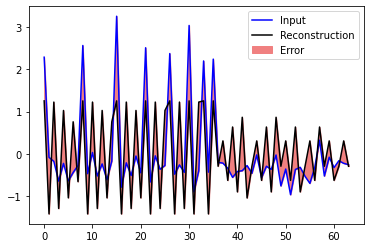

In [83]:
ind = 40
plt.plot(data_test[ind],'b')
plt.plot(decoded_data[ind],'k')
plt.fill_between(np.arange(64),decoded_data[ind],data_test[ind],color='lightcoral')
plt.legend(["Input", "Reconstruction","Error"])
# plt.savefig('SNR_-30_autoencoder_compare.png')

In [57]:
# RF TEST DATA
x_test = sio.loadmat('vec')
test_max = x_test['vec']
test_max = test_max.reshape(1,64)

# scaling
# data_test = scaler.fit_transform(data_test)
test_max_scale = scaler.fit_transform(np.transpose(test_max))
# print(data_test_scale.shape)
test_data = np.transpose(test_max_scale)
# print(data_test.shape)

# export data for MATLAB processing
print(savePath)
savePath_ = savePath + '/test_data.mat'
print(savePath_)
savemat(savePath_, {'test_data':test_data})

FileNotFoundError: [Errno 2] No such file or directory: 'vec.mat'

In [ ]:
decoded_data = reconstructedValue(data_test,model)
print(decoded_data.shape)

# Save the denoised data for MATLAB processing
print(savePath)
savePath_ = savePath + '/denoised_data.mat'
print(savePath_)
savemat(savePath_, {'denoised_data':decoded_data})